# Methode combiné de l'Oscillateur Stochastique sur l'indice BRVM-Secteurs-Publics

## importation des librairies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime 
from print_color import print
import locale
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

'fr_FR.UTF-8'

In [2]:
#boab = yf.download("AMZN","2021-11-24","2023-05-10")
#boab.to_csv("AMAZON_2021-11-24_2023-05-10.csv")
#print(len(boab))
#boab = pd.read_csv("AMAZON_2021-11-24_2023-05-10.csv")
#boab = boab.set_index(boab["Date"]).drop("Date",axis=1)


In [3]:
BOAB = pd.read_csv("../data/BRVM-Public-Services.csv",index_col="Date")

In [4]:
debut = -365
fin = len(BOAB)
boab = BOAB.iloc[debut:]

# Oscillateur Stochastique

In [5]:
low = 14#14
hight = 14#14
d = 3#3
l = 1

In [ ]:
#Determinons si le marche est un surachat ou en survente 
prix_bas = boab['Low'].rolling(low).min()
prix_eleve = boab['High'].rolling(hight).max()
cloture = boab["Close"]

boab["%k"] = ((cloture - prix_bas) / (prix_eleve - prix_bas)) * 100
boab["%d"] = boab['%k'].rolling(d).mean()

# Moyenne mobile convergence divergence

In [7]:
rapide_ = 6#12 ; 6
lente_ =  10 #26 ; 10 
signal_ = 7 #9 ; 7

In [8]:
#determination de l'indicateur moyenne mobile convergence divergence

ema_rapide = cloture.ewm(span = rapide_ , adjust = False).mean()
ema_lente = cloture.ewm(span = lente_, adjust = False).mean()

# MACD
macd = pd.DataFrame(ema_rapide - ema_lente).rename(columns = {'Close':'MACD'})

# SIGNALE
ema_macd = macd.ewm(span=signal_,adjust=False).mean()
signale = pd.DataFrame(ema_macd.rename(columns={"MACD":"Signale"}))

# HISTOGRAMME
histogramme = pd.DataFrame(macd['MACD']-signale['Signale']).rename(columns = {0:"hist"})
histogramme.tail() ;


In [ ]:
boab['MACD'] = macd
boab['Signale'] = signale
boab["Histogramme"] = histogramme


## Nous achetons et ne vendons en nous basant à la fois sur MACD et le RSI

In [ ]:
# strategie de trading
cloture = boab['Close']
macd = boab['MACD']
signale_macd = boab['Signale']
k = boab['%k']
d = boab['%d']
stock = 0 

prix_achat = []
prix_vente = []

stoc_macd_signal = []
position = []
signal_achat = []
signal_vente = []
achat_et_vente = []


for i in range(len(cloture)) :

    if k.iloc[i]<30 and d.iloc[i]<30 and macd.iloc[i]<-l and signale_macd.iloc[i]<-l :
        signal_achat.append(cloture.iloc[i])
        signal_vente.append(np.nan)
        
        if stock != 1 and cloture.iloc[i]>0 :
            achat_et_vente.append("acheter")
            prix_achat.append( cloture.iloc[i] )
            prix_vente.append( np.nan )
            stock = 1
            stoc_macd_signal.append(0)
            position.append(1)

        else :
            achat_et_vente.append(np.nan)
            prix_achat.append(np.nan)
            prix_vente.append(np.nan)
            stoc_macd_signal.append(0)
            position.append(1)

    elif k.iloc[i]>70 and d.iloc[i]>70 and macd.iloc[i]>l and signale_macd.iloc[i]>l :
        signal_vente.append(cloture.iloc[i])
        signal_achat.append(np.nan)

        if stock != -1 and stock != 0 :
            achat_et_vente.append("vendre")
            prix_vente.append( cloture.iloc[i] )
            prix_achat.append( np.nan )
            stock = -1
            stoc_macd_signal.append(stock)
            position.append(0)
        
        else :
            achat_et_vente.append(np.nan)
            prix_achat.append(np.nan)
            prix_vente.append(np.nan)
            stoc_macd_signal.append(0)
            position.append(0)
    
    else :
        achat_et_vente.append(np.nan)
        signal_achat.append(np.nan)
        signal_vente.append(np.nan)

        prix_achat.append( np.nan )
        prix_vente.append( np.nan )
        stoc_macd_signal.append(0)
        
        if stock == 0 :
            position.append(0)
        
        else :
            position.append(position[i-1])

boab['achat_vente'] = achat_et_vente



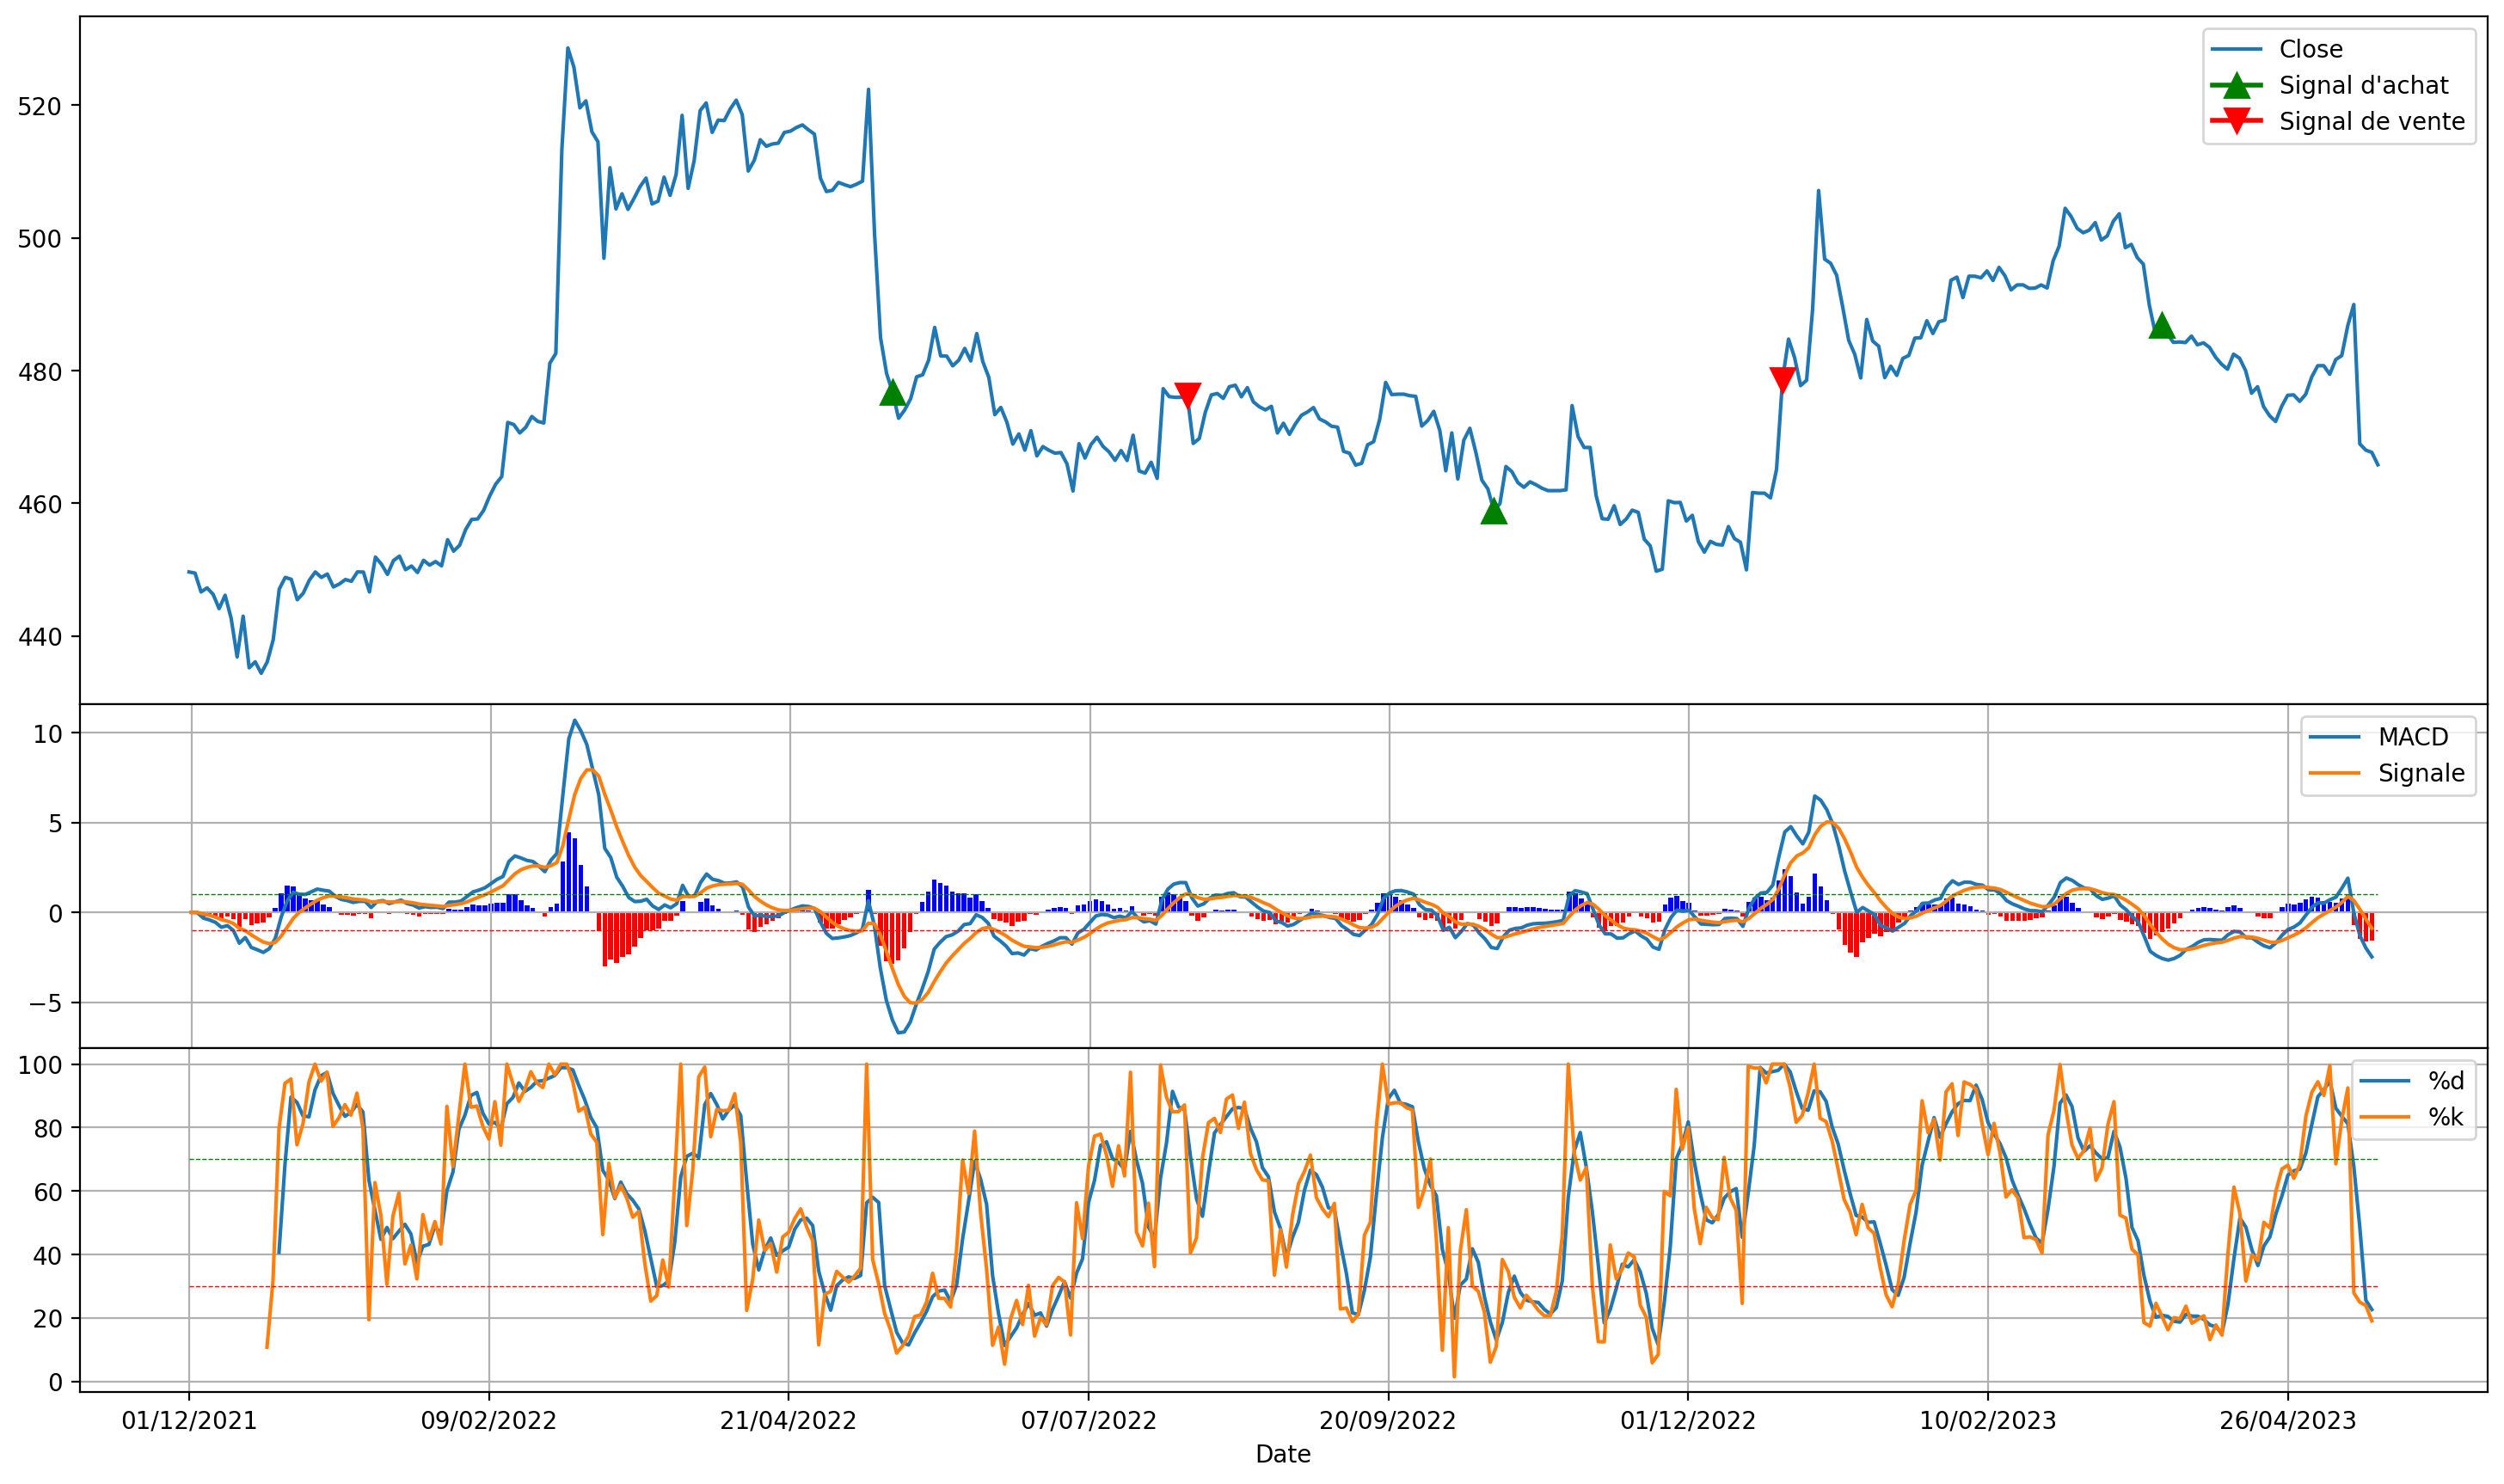

In [11]:
fig  = plt.figure(figsize=(14,4) , dpi=200) 

axe1 = fig.add_axes([0,1,1,1])
boab['Close'].plot()
axe1.plot(boab.index ,prix_achat , marker='^',color='green',markersize=10,label = "Signal d'achat",linewidth=2)
axe1.plot(boab.index ,prix_vente , marker='v',color='red',markersize=10,label = "Signal de vente",linewidth=2)
plt.legend()

axe2 = fig.add_axes([0,0.5,1,0.5])
boab['MACD'].plot()
boab['Signale'].plot()

hist = boab['Histogramme'].values
couleurs = ['red' if valeur < 0 else 'blue' for valeur in hist ]
# Tracé de l'histogramme avec des barres colorées
plt.bar(boab.index, hist, color=couleurs)

plt.plot([0,len(boab)] , [l,l] , color='green' ,linestyle='--', linewidth=0.5)
plt.plot([0,len(boab)] , [-l,-l] , color='red' ,linestyle='--', linewidth=0.5)
plt.grid(True)
plt.legend()

axe3 = fig.add_axes([0,0,1,0.5]) 
boab["%d"].plot(label = "%d")
boab['%k'].plot(label = '%k')
plt.plot([0,len(boab)] , [70,70] , color='green',linestyle='--' , linewidth=0.5)
plt.plot([0,len(boab)] , [30,30] , color='red' , linestyle='--',linewidth=0.5)
plt.grid(True)
plt.legend()


## Backtesting

In [12]:
benefice_total = 0
depart = 1000
d=depart
nombre = 0
total = 0

for i in range( len( boab ) ) :
    if boab['achat_vente'].iloc[i] == 'acheter' :

        nombre = depart/boab['Close'].iloc[i]
        entrer = nombre*boab['Close'].iloc[i]
        print("Achat : ",boab['Close'].iloc[i])
        
    elif boab['achat_vente'].iloc[i] == 'vendre' :
        print("Vendre : ",boab['Close'].iloc[i])
        sorti = (nombre*boab['Close'].iloc[i])
        benefice_total += sorti-entrer
        depart = sorti

pourcentage_benefice = 100*(benefice_total/d)

Achat :  476.73
Vendre :  476.31
Achat :  458.93
Vendre :  478.63
Achat :  486.9


In [13]:
date_depart = datetime.strptime( BOAB.iloc[debut].name , "%d/%m/%Y" ).strftime("%A %d %B, %Y ")
date_fin = datetime.strptime( BOAB.iloc[fin-1].name , "%d/%m/%Y" ).strftime("%A %d %B, %Y ")

print("Avec un capitale de depart de " ,end="")
print("{:,.2f} Fcfa".format(d) , color='green')
print("nous avons réalisé un benefice de ",end='')
print("{:.2f} %".format(pourcentage_benefice) , color='green')
print("Soit un benefice total de ",end='')
print("{:,.2f} Fcfa".format(pourcentage_benefice) , color='green')
print("Sur la periode allant du ",end='')
print(date_depart , color="blue" , end="") ; print(" au " ,end="")
print(date_fin , color="blue" , end="")

Avec un capitale de depart de 1,000.00 Fcfa
nous avons réalisé un benefice de 4.20 %
Soit un benefice total de 4.20 Fcfa
Sur la periode allant du mercredi 01 décembre, 2021  au vendredi 19 mai, 2023 

In [14]:
format_ = "%Y-%m-%d"
format__ = "%d/%m/%Y"
date_depart = datetime.strptime( BOAB.iloc[debut].name , format__  ).strftime("%A %d %B, %Y ")
date_fin = datetime.strptime( BOAB.iloc[fin-1].name , format__ ).strftime("%A %d %B, %Y ")

print("Avec un capitale de depart de " ,end="")
print("{:,.2f} Fcfa".format(d) , color='green')
print("nous avons réalisé un benefice de ",end='')
print("{:.2f} %".format(pourcentage_benefice) , color='green')
print("Soit un benefice total de ",end='')
print("{:,.2f} Fcfa".format(benefice_total) , color='green')
print("Sur la periode allant du ",end='')
print(date_depart , color="blue" , end="") ; print(" au " ,end="")
print(date_fin , color="blue" , end="")

Avec un capitale de depart de 1,000.00 Fcfa
nous avons réalisé un benefice de 4.20 %
Soit un benefice total de 42.01 Fcfa
Sur la periode allant du mercredi 01 décembre, 2021  au vendredi 19 mai, 2023 